In [ ]:
if "google.colab" in str(get_ipython()):
    # uninstall preinstalled packages from Colab to avoid conflicts
    #!pip uninstall -y torch notebook notebook_shim tensorflow tensorflow-datasets prophet torchaudio torchdata torchtext torchvision
    #!pip install neuralprophet
    #!pip install mlflow
    print('o')

from neuralprophet import NeuralProphet, set_log_level
import mlflow
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#disable logging unless error
set_log_level("ERROR")

#Set up MLFlow via DAGSHub
os.environ['MLFLOW_TRACKING_USERNAME'] = '2Duffman'
os.environ['MLFLOW_TRACKING_PASSWORD'] = 'f6651f529b37bdd5aa99d6a092e7d48359374423'
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = 'Symbolic-Regression'
mlflow.set_tracking_uri(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME']
                        + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')

Now we will read the data and fix all the missing 00:00:00

In [44]:
# Read the data
if "google.colab" in str(get_ipython()):
  data = pd.read_csv('drive/MyDrive/distance_8.csv')
else:
  data = pd.read_csv("distance_8.csv")

# Define the target column
target = "saldo_final_target"

# Function to check if time is present in the string
def check_time(s):
    first_colon = s.find(':')
    if first_colon == -1:
        return s + ' 00:00:00'
    else:
        return s

# Apply the function to the 'delivery_start' column
data['delivery_start'] = data['delivery_start'].apply(check_time)

# Convert 'delivery_start' to datetime
data['delivery_start'] = pd.to_datetime(data['delivery_start'], format='%Y-%m-%d %H:%M:%S')

# Create 'year' column
data['year'] = data['delivery_start'].dt.year

# Create 'day' column with day of the year
data['day'] = data['delivery_start'].dt.dayofyear

# Create 'time' column with minutes since midnight
data['time'] = data['delivery_start'].dt.hour * 60 + data['delivery_start'].dt.minute

# Create cyclic representations of 'day' and 'time'
#data['day_sin'] = np.sin(2 * np.pi * data['day'] / 365)
#data['day_cos'] = np.cos(2 * np.pi * data['day'] / 365)
#data['time_sin'] = np.sin(2 * np.pi * data['time'] / 1440)
#data['time_cos'] = np.cos(2 * np.pi * data['time'] / 1440)

# Drop 'day' and 'time' columns
data = data.drop(['day', 'time', 'floor_day_target'], axis=1)
data = data.rename(columns={'delivery_start': 'ds', target: 'y'})

columnsToKeep = ['ds','y']
lagged_regressors_list = []
future_regressors_list = []
for col in data.columns:
      if 'target' in col:
          future_regressors_list.append(col)
      elif 'latest' in col:
          lagged_regressors_list.append(col)

# this removes all columns not 'ds','y' or any regressors
data = data[data.columns.intersection(np.concatenate((columnsToKeep, lagged_regressors_list, future_regressors_list)))]

Transform the data into actual time series. Don't be confused from here on: the 'target' variables will be refering to the timestamp they are in (not anymore 8 steps ahead!)

In [45]:
# Shift the columns in future_regressors_list and 'y' down by 8 rows
for col in future_regressors_list + ['y']:
    data[col] = data[col].shift(8)

# Drop the first 8 rows
data = data.dropna().reset_index(drop=True)
data.head()

,ds,da_price_target,holiday_or_weekend_target,max_daily_temperature_target,max_daily_temperature_week_target,max_daily_temperature_hist_target,max_daily_temperature_hist_week_target,max_daily_temperature_hist_smooth_target,min_daily_temperature_target,min_daily_temperature_week_target,...,UDI_NET_latest,WP_CTRL_NET_latest,cloudiness_latest,official_latest,weighted_sd_latest,weighted_sd_week_mean_latest,avg_price_AFRR_negative_latest,avg_price_AFRR_positive_latest,avg_price_MFRR_negative_latest,avg_price_MFRR_positive_latest
0,2020-08-01 03:45:00,1987.0,0.5,24.51,20.85,22.09,21.66,20.98,23.55,19.98,...,-49300,0,16.6,0,478,1055.046131,457,5642,-13246,16804
1,2020-08-01 04:00:00,3020.0,0.5,24.51,20.85,22.09,21.66,20.98,23.55,19.98,...,-35700,0,19.0,0,390,1054.934524,457,5642,-13246,16804
2,2020-08-01 04:15:00,3017.0,0.5,24.51,20.85,22.09,21.66,20.98,23.55,19.98,...,-36800,0,19.0,0,535,1054.511905,457,5642,-13246,16804
3,2020-08-01 04:30:00,2908.0,0.5,24.51,20.85,22.09,21.66,20.98,23.55,19.98,...,-42800,0,19.0,0,518,1054.190476,457,5642,-13246,16804
4,2020-08-01 04:45:00,2390.0,0.5,24.51,20.85,22.09,21.66,20.98,23.55,19.98,...,-32200,0,19.0,0,579,1053.940476,457,5642,-13246,16804


In [17]:
model = NeuralProphet(
    #n_forecasts=1,
    #n_lags=10,
    #yearly_seasonality=True,
    #weekly_seasonality=True,
    #daily_seasonality=True,
    #batch_size=64,
    #epochs=100,
    #learning_rate=1.0,
)

model.add_lagged_regressor(names = lagged_regressors_List)
#for regressor in future_regressors_List:
#    model.add_future_regressor(name = regressor)
# create a test holdout set:
df_train, df_test = model.split_df(df=data, freq="15min", valid_p=0.1)
metrics_train = model.fit(df=df_train, freq="15min", epochs=20)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alte

KeyboardInterrupt: 

In [15]:
#num_rows = df_test.shape[0]
#df_future = model.make_future_dataframe(df_train, periods=num_rows, n_historic_predictions=len(df_train))
set_log_level("ERROR")
metrics_test = model.test(df=df_test)


WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

  converted_ds = pd.to_datetime(ds_col, utc=True).view(dtype=np.int64)

WARNING - (py.warnings._showwarnmsg) - /usr/local/lib/python3.10/dist-packages/neuralprophet/df_utils.py:1152: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alte

ValueError: Unexpected column da_price_mean_target in data

AssertionError: 

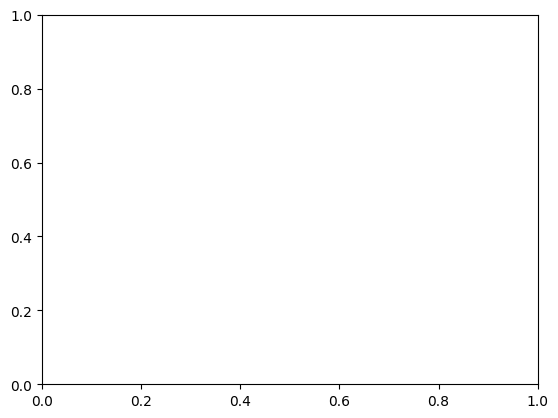

In [ ]:
model.set_plotting_backend("matplotlib")
fig, ax = plt.subplots()
#model.plot(forecast, ax = Axes.set_xlim([pd.Timestamp('2022-01-01 00:00:00'),pd.Timestamp('2022-01-03 23:45:00')]))
model.plot(forecast, ax = ax)
ax.set_xlim([pd.Timestamp('2022-01-01 00:00:00'),pd.Timestamp('2022-01-03 23:45:00')])
plt.show()
